In [1]:
import numpy as np
import pandas as pd
import os
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import fcwt
%matplotlib inline

### Import and process KPLO Data

In [2]:

"Load KMAG Data"
kmag = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230116_GSE_1sec.csv')

"Load THEMIS Data"
themis = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230116_themis_thb_fgm_fgs_l2.csv')
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th = np.vstack((Bx_th, By_th, Bz_th))
themis_t = pd.to_datetime(themis['UTC']).to_numpy()

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z));
B_2b = np.vstack((B2_x, B2_y, B2_z)); 
B_1b = np.vstack((B1_x, B1_y, B1_z)); 
B = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
t = pd.to_datetime(kmag['UTC']).to_numpy()

In [3]:
"Find gaps"
B = B[:,:,100:-100]; t = t[100:-100]
gaps = 1- np.isnan(B[0,0])
g = 1 - np.isnan(B[0,0])
print(np.sum(1-gaps))

1326


### Interpolate the data


In [4]:
from magprime.utility import interpolation
interpolation.mssa.n_components = "parallel_analysis"
interpolation.mssa.pa_percentile_threshold = 5
interpolation.mssa.verbose = False
print(B.shape)
B_interpolated_x = interpolation.mssa.interpolate(np.copy(B[:,0]), np.copy(gaps), triaxial=False)
B_interpolated_y = interpolation.mssa.interpolate(np.copy(B[:,1]), np.copy(gaps), triaxial=False)
B_interpolated_z = interpolation.mssa.interpolate(np.copy(B[:,2]), np.copy(gaps), triaxial=False)


c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(3, 3, 86200)


  0%|          | 0/44 [00:00<?, ?it/s]c:\Users\alexp\anaconda3\lib\site-packages\pymssa\optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  components = _incremental_component_reconstruction_inner(
c:\Users\alexp\anaconda3\lib\site-packages\pymssa\optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  components = _incremental_component_reconstruction_inner(
100%|██████████| 44/44 [05:21<00:00,  7.30s/it] 


In [12]:
B_interpolated = np.stack((B_interpolated_x, B_interpolated_y, B_interpolated_z), axis=1)
np.save('B_interpolated.npy', B_interpolated)

In [5]:
# Load the array from the .npy file
B_interpolated = np.load('B_interpolated.npy')

In [6]:

def find_gaps(gaps):
    # Find Gap starting and ending indices
    gap_indices = np.where(gaps == 0)[0]
    if gap_indices.size == 0:
        return []  # No gaps to fill

    gap_starts = np.hstack(([0], np.where(np.diff(gap_indices) != 1)[0] + 1))
    gap_ends = np.hstack((np.where(np.diff(gap_indices) != 1)[0], [len(gap_indices) - 1]))
    full_gaps = [(gap_indices[start], gap_indices[end]) for start, end in zip(gap_starts, gap_ends)]

    # Create a list to store gap info with window analysis
    gap_info = []

    for start, end in full_gaps:
        gap_length = end - start + 1
        window_radius = 2 * gap_length
        window_start = max(0, start - window_radius)
        window_end = min(len(gaps) - 1, end + window_radius)

        # Count valid data points in the window
        window_data_count = np.sum(gaps[window_start:start]) + np.sum(gaps[end + 1:window_end + 1])

        gap_info.append((start, end, gap_length, int(window_data_count//gap_length > 3)))

    # Rank gaps - example by smallest gap first, then by maximum surrounding data
    gap_info.sort(key=lambda x: (-x[3],x[2]))
    return(gap_info)

gap_info = find_gaps(g)
print(gap_info[-10:])

[(32266, 32275, 10, 1), (32536, 32545, 10, 1), (19512, 19522, 11, 1), (81391, 81427, 37, 1), (80746, 80801, 56, 1), (80962, 81017, 56, 1), (80523, 80581, 59, 1), (81171, 81180, 10, 0), (81182, 81238, 57, 0), (14070, 14797, 728, 0)]


### RAMEN and WAICUP

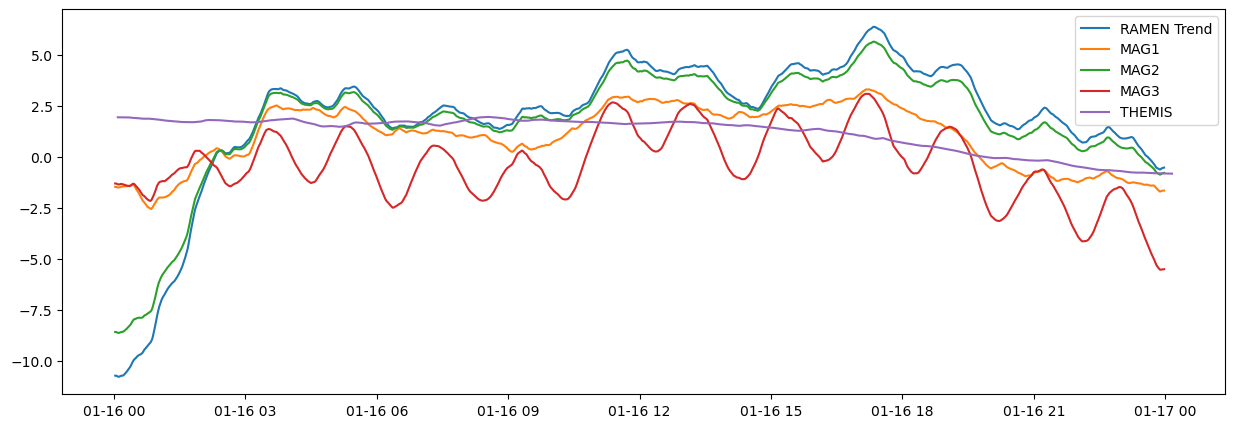

In [81]:
"Detrend"
sensors = np.copy(B_interpolated)
uf = int(8640*1.1)
trend = uniform_filter1d(sensors, size=uf)
sensors = sensors - trend
themis_trend = uniform_filter1d(B_th, size=uf)
"Apply RAMEN"
from magprime.algorithms import RAMEN
#RAMEN.aii = np.array([4.20294038, 1.66256108, 2.73986213])
#RAMEN.aii = np.array([ 7.01002316, 75.24653706,  6.26681301])
RAMEN.aii = np.array([7.47853459, 4.31977126, 6.22436556])
#RAMEN.aii = np.array([24.50088243,  1.58003374, 15.6815788 ])
ramen_trend = RAMEN.clean(trend[:2])

"""
Note: 
RAMEN.aii = np.array([ 7.01002316, 75.24653706,  6.26681301]), uf = 8640*1
RAMEN.aii = np.array([7.47853459, 4.31977126, 6.22436556]), uf = 8640*1
"""

"Plot"
plt.figure(figsize=(15, 5))
plt.plot(t, ramen_trend[1], label='RAMEN Trend')
plt.plot(t, trend[:,1].T, label=['MAG1', 'MAG2', 'MAG3'])
plt.plot(themis_t, themis_trend[1], label='THEMIS')
plt.legend()
#aii = np.array([7.47853459, 4.31977126, 6.22436556])

In [21]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = False # Detrend the data
#WAICUP.uf = 8640*4 # Number of points in uniform filter (uf)
#WAICUP.aii = np.array([ 7.01002316, 75.24653706,  6.26681301]) # Coupling Coefficients

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(sensors), triaxial=True)

c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  waicup_level1[i] = dual(np.vstack((sig[pairs[i][0]], sig[pairs[i][1]])), dt, dj)
c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


Text(0.5, 0, 'Time (UTC)')

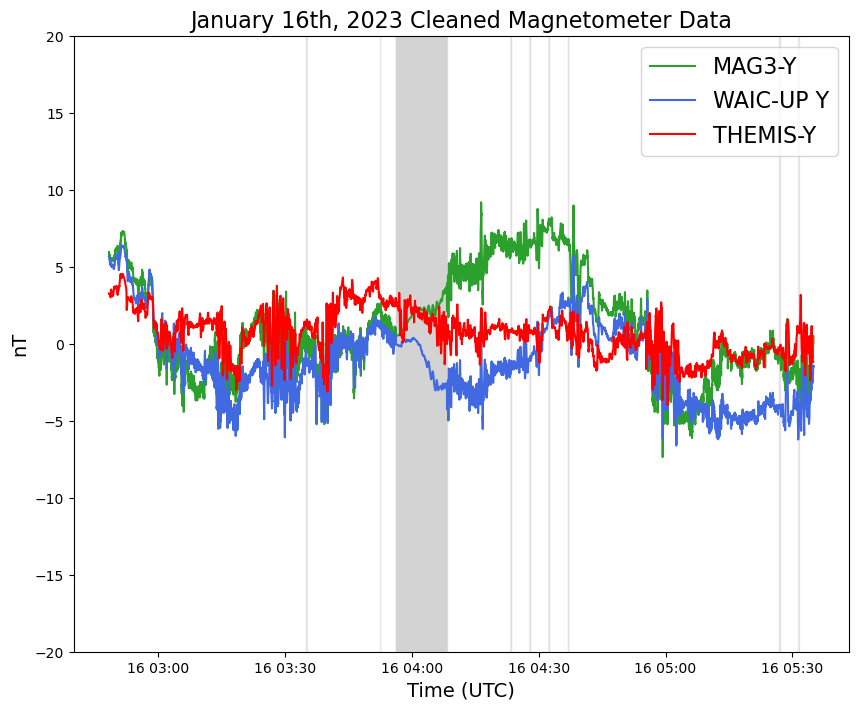

In [84]:
"Cleaned Magnetometer Data"
B_clean = B_WAICUP + ramen_trend
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axis = 2
t_start = 0
th_start = 2276+0; th_end = 4603+0
gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]
axs.set_ylim(-20, 20)
for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)
axs.set_title("January 16th, 2023 Cleaned Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B_interpolated[2,axis,10000+t_start:20000+t_start].T, label="MAG3-Y", color='#2ca02c')
axs.plot(t[10000+t_start:20000+t_start], B_clean[axis,10000+t_start:20000+t_start], label="WAIC-UP Y", color = 'royalblue')
axs.plot(themis_t[th_start:th_end], B_th[axis,th_start:th_end], label="THEMIS-Y", color = 'red')
axs.legend(loc=1, fontsize=16)
axs.set_ylabel("nT", fontsize=14)
axs.set_xlabel("Time (UTC)", fontsize=14)


1326


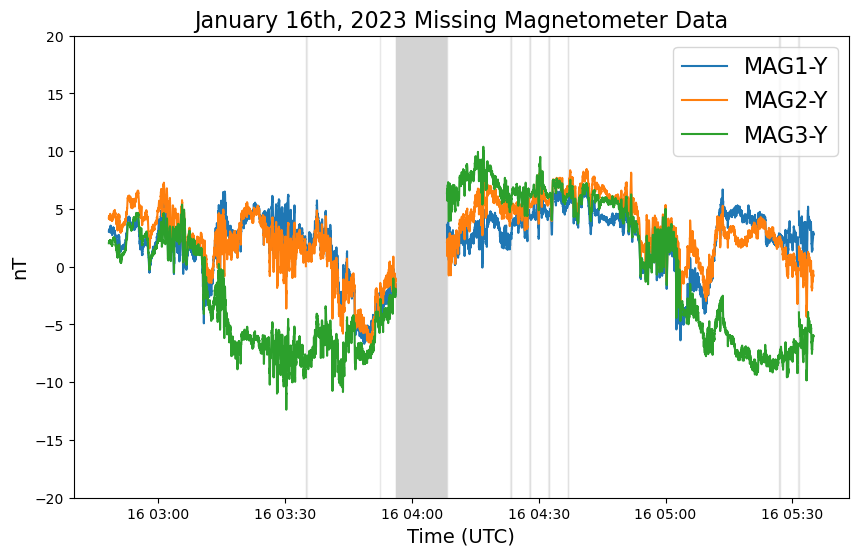

In [16]:
t_start = 0
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Missing Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B[:,1,10000+t_start:20000+t_start].T, label=["MAG1-Y", "MAG2-Y", "MAG3-Y"])
axs.set_ylim(-20, 20)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)

print(np.sum(g == 0))

1326


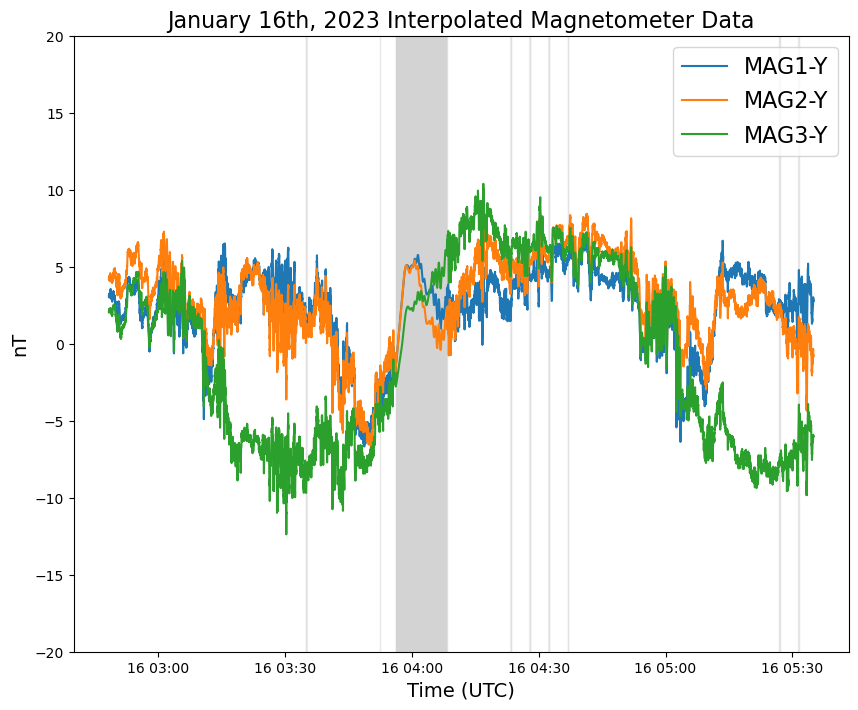

In [17]:
t_start = 0
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Interpolated Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B_interpolated[:,1,10000+t_start:20000+t_start].T, label=["MAG1-Y", "MAG2-Y", "MAG3-Y"])
axs.set_ylim(-20, 20)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)

print(np.sum(g == 0))